<a href="https://colab.research.google.com/github/Android998/TensorFlow2.3/blob/master/TFG3.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Paso 1: Importar las librerias**

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## **Paso 2:Pre procesado de datos**

In [2]:
drive.mount("/content/drive")
base_dir = "./drive/My Drive/object_photos2.0"

Mounted at /content/drive


In [41]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)


In [42]:
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

print(len(train_generator))

Found 12801 images belonging to 40 classes.
1601


In [43]:
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')
print(len(val_generator))

Found 3200 images belonging to 40 classes.
400


In [6]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((8, 224, 224, 3), (8, 40))

### **Generamos el archivo labels con las etiquetas de los objetos**

In [7]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'backpack': 0, 'bed': 1, 'belt': 2, 'blind stick': 3, 'bottle': 4, 'carpet': 5, 'cellular phone': 6, 'chair': 7, 'cup-glass': 8, 'door': 9, 'eyeglasses': 10, 'fan': 11, 'handkerchief': 12, 'headphones': 13, 'keys': 14, 'laptop': 15, 'mouse': 16, 'newspaper': 17, 'notebook': 18, 'pen': 19, 'pencil': 20, 'pillow': 21, 'plate': 22, 'plug': 23, 'printer': 24, 'radiator': 25, 'remote control': 26, 'shoes': 27, 'shorts': 28, 'socks': 29, 't-shirts': 30, 'table': 31, 'television': 32, 'toothbrush': 33, 'towel': 34, 'trash bin': 35, 'wallet': 36, 'wardrobe': 37, 'watch': 38, 'window (shade)': 39}


## **Paso 3: Crear el modelo base ya entrenado**

In [26]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

94674944/94668760 [==============================] - 2s 0us/step


In [27]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### **Añadir ultima capa**

In [28]:
base_model.trainable = False

In [29]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(40, activation='softmax')
])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          589856    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1320      
Total params: 24,155,976
Trainable params: 591,176
Non-trainable params: 23,564,800
_________________________________________________________________


### **Compilar y entrenar el modelo**

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [32]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=10, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
201/201 [==============================] - 82s 409ms/step - loss: 2.0555 - accuracy: 0.4818 - val_loss: 1.4937 - val_accuracy: 0.6209
Epoch 2/10
201/201 [==============================] - 82s 406ms/step - loss: 1.1541 - accuracy: 0.6905 - val_loss: 1.3879 - val_accuracy: 0.6463
Epoch 3/10
201/201 [==============================] - 81s 405ms/step - loss: 0.7974 - accuracy: 0.7720 - val_loss: 1.3570 - val_accuracy: 0.6800
Epoch 4/10
201/201 [==============================] - 82s 407ms/step - loss: 0.5811 - accuracy: 0.8288 - val_loss: 1.3171 - val_accuracy: 0.6903
Epoch 5/10
201/201 [==============================] - 82s 407ms/step - loss: 0.4244 - accuracy: 0.8711 - val_loss: 1.3872 - val_accuracy: 0.6869
Epoch 6/10
201/201 [==============================] - 82s 410ms/step - loss: 0.3419 - accuracy: 0.8958 - val_loss: 1.4414 - val_accuracy: 0.6981
Epoch 7/10
201/201 [==============================] - 82s 406ms/step - loss: 0.2499 - accuracy: 0.9251 - val_loss: 1.4414 - val_ac

### **Evaluar el modelo**

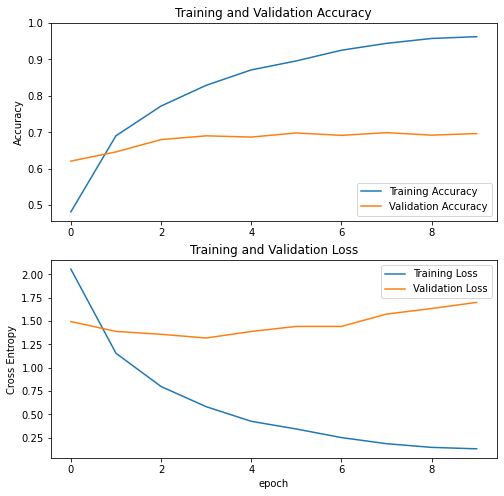

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **Paso 4: Fine Tuning**

In [34]:
base_model.trainable = True

In [35]:
print("Number of layersin the base model: {}".format(len(base_model.layers)))

Number of layersin the base model: 190


In [36]:
fine_tune_at = 100

In [37]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### **Compilar y entrenar el modelo**

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [39]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=5, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/5
201/201 [==============================] - 91s 451ms/step - loss: 0.6535 - accuracy: 0.8062 - val_loss: 1.1843 - val_accuracy: 0.7262
Epoch 2/5
201/201 [==============================] - 93s 463ms/step - loss: 0.1823 - accuracy: 0.9455 - val_loss: 1.2363 - val_accuracy: 0.7497
Epoch 3/5
201/201 [==============================] - 94s 469ms/step - loss: 0.0941 - accuracy: 0.9717 - val_loss: 1.3018 - val_accuracy: 0.7341
Epoch 4/5
201/201 [==============================] - 96s 475ms/step - loss: 0.0921 - accuracy: 0.9733 - val_loss: 1.2526 - val_accuracy: 0.7306
Epoch 5/5
201/201 [==============================] - 95s 473ms/step - loss: 0.0890 - accuracy: 0.9738 - val_loss: 1.2552 - val_accuracy: 0.7575


### **Evaluacion de resultados**

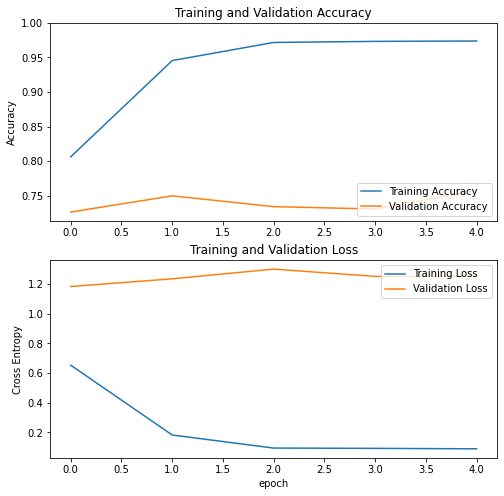

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **Seguimos entrenando ya que aun hay margen de mejora**

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

In [45]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=5, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/5
1601/1601 [==============================] - 130s 81ms/step - loss: 0.3106 - accuracy: 0.9088 - val_loss: 1.1360 - val_accuracy: 0.7731
Epoch 2/5
1601/1601 [==============================] - 132s 83ms/step - loss: 0.1768 - accuracy: 0.9483 - val_loss: 1.1673 - val_accuracy: 0.7775
Epoch 3/5
1601/1601 [==============================] - 132s 83ms/step - loss: 0.1161 - accuracy: 0.9680 - val_loss: 1.2157 - val_accuracy: 0.7763
Epoch 4/5
1601/1601 [==============================] - 133s 83ms/step - loss: 0.0840 - accuracy: 0.9780 - val_loss: 1.2285 - val_accuracy: 0.7831
Epoch 5/5
1601/1601 [==============================] - 132s 83ms/step - loss: 0.0722 - accuracy: 0.9814 - val_loss: 1.2269 - val_accuracy: 0.7800


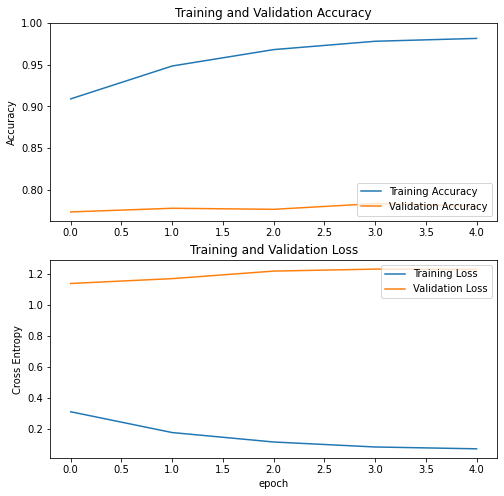

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **Cargar el modelo de TFLite**

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: save/fine_tuning/assets


INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>